https://www.kaggle.com/code/amitvkulkarni/lime-for-explainability-in-python/notebook

In [3]:
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')
df_submission = pd.read_csv('./dataset/sample_submission.csv')


print(f'Shape of train data: {df_train.shape}')
print(f'Shape of test data: {df_test.shape}')


SEED = 12
n_trials = 2
target = 'Exited'

df_train = df_train.drop(['id', 'Surname'], axis = 1)
df_test = df_test.drop(['id', 'Surname'], axis = 1)


features = df_train.columns.drop(target)
CAT_FEATS = df_train.select_dtypes(include='object').columns
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != target and x in features]

assert target not in features
assert target not in CAT_FEATS
assert target not in NUM_FEATS


# Encode all the categorical features
df_train_cat_encode = df_train[CAT_FEATS]
df_test_cat_encode= df_test[CAT_FEATS]

# Dummify the train and test data
df_train_cat_encoded = pd.get_dummies(df_train_cat_encode, columns = CAT_FEATS, drop_first=True)
df_test_cat_encoded = pd.get_dummies(df_test_cat_encode, columns = CAT_FEATS, drop_first=True)


# Scale all the numerical features
df_train_num_scale = df_train[NUM_FEATS]
df_test_num_scale = df_test[NUM_FEATS]

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(df_train_num_scale)

# Scale the training data
df_train_num_scaled = minmax_scaler.transform(df_train_num_scale)
df_train_num_scaled = pd.DataFrame(df_train_num_scaled, columns=df_train_num_scale.columns)

# Scale the test data using the parameters from the training data
df_test_num_scaled = minmax_scaler.transform(df_test_num_scale)
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=df_test_num_scale.columns)


# Concatenate datasets
df_train_combined = pd.concat([df_train_cat_encoded.reset_index(drop=True), df_train_num_scaled.reset_index(drop=True)], axis=1)

# Concatenate test datasets
df_test_combined = pd.concat([df_test_cat_encoded.reset_index(drop=True), df_test_num_scaled.reset_index(drop=True)], axis=1)


df_train_combined['Exited'] = df_train['Exited']

df_train_combined = df_train_combined.head(500)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_train_combined.drop(columns=[target])
y = df_train_combined[target]

Shape of train data: (165034, 14)
Shape of test data: (110023, 13)


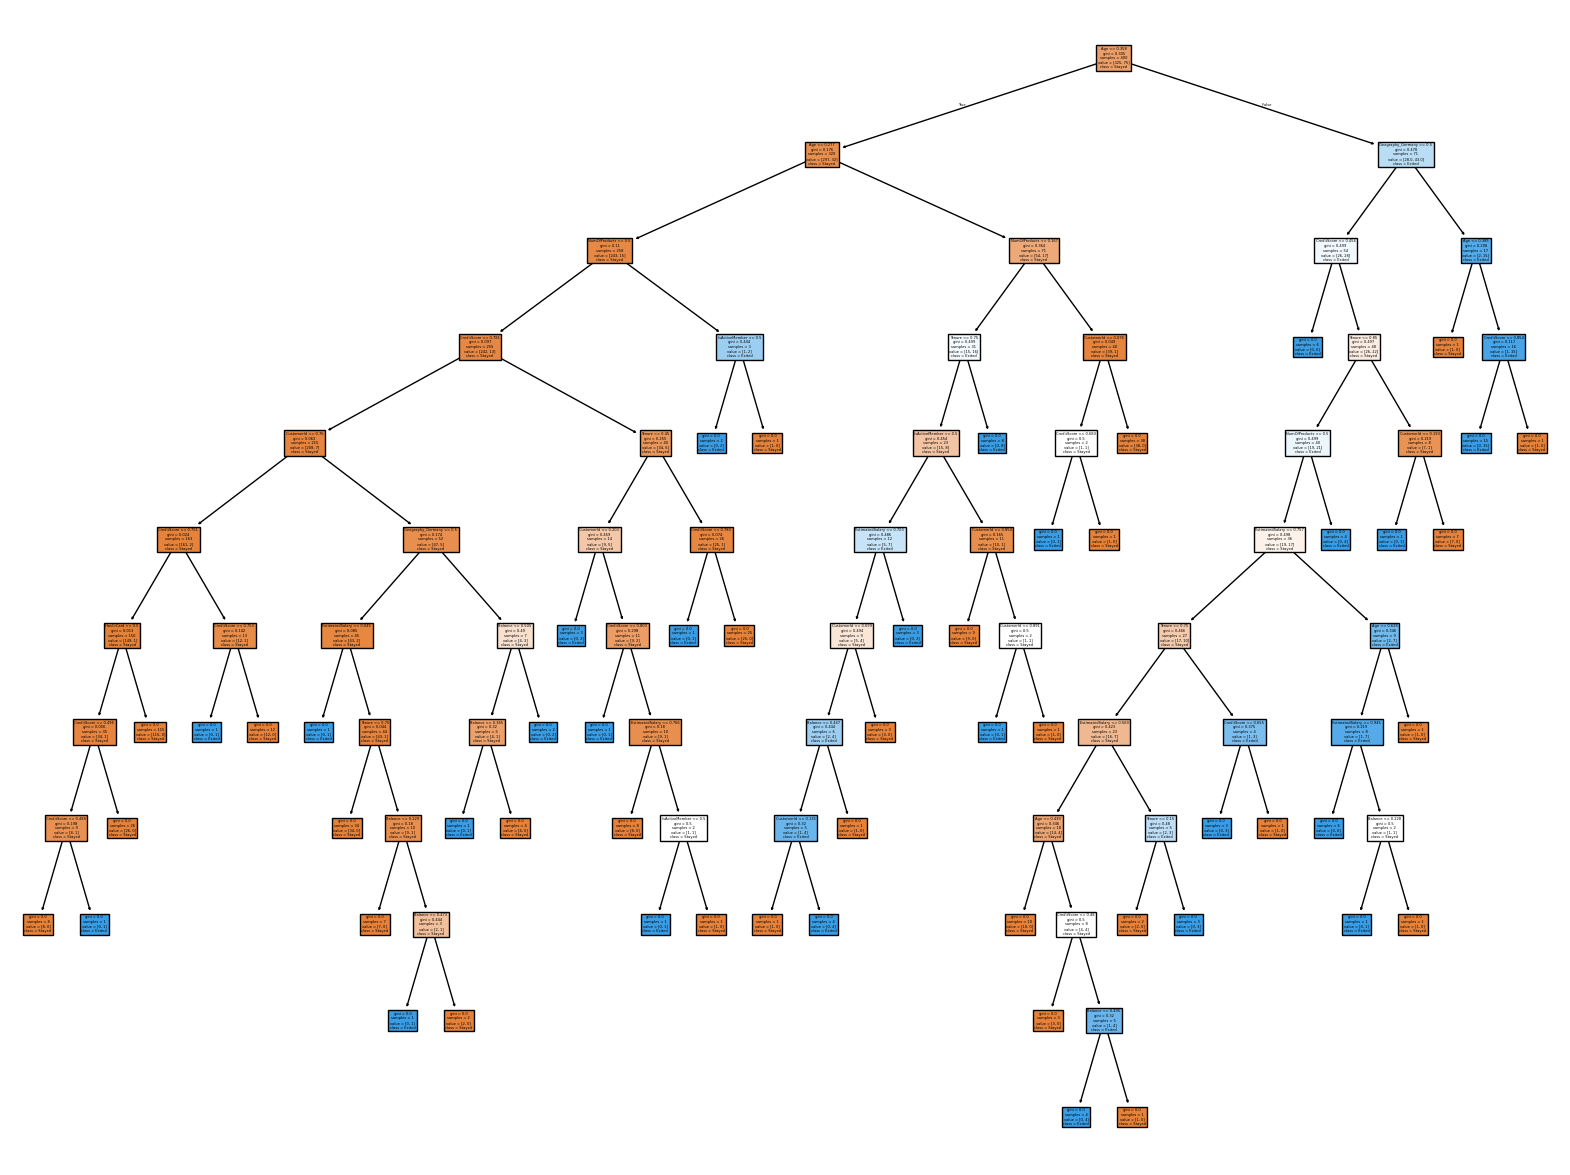

Training Accuracy: 1.0
Test Accuracy: 0.72


In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Decision Tree classifier
clf_DecisionTree = DecisionTreeClassifier(random_state=42)
clf_DecisionTree.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(20,15))
plot_tree(
    clf_DecisionTree,
    filled=True,
    feature_names=X.columns,       # all feature names
    class_names=['Stayed', 'Exited']  # must be a list of strings
)
plt.show()

# Evaluate the model
y_pred_train = clf_DecisionTree.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = clf_DecisionTree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Logistic Regression model with increased max_iter
clf_LogisticRegression = LogisticRegression(max_iter=1000, random_state=42)
clf_LogisticRegression.fit(X_train, y_train)

# Evaluate the model
train_accuracy = clf_LogisticRegression.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

test_accuracy = clf_LogisticRegression.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


# Predict probabilities and class for any given record (in this case, the first record in the test set)
record_index = 1
predicted_probabilities = clf_LogisticRegression.predict_proba(X_test.iloc[[record_index]])
predicted_class = clf_LogisticRegression.predict(X_test.iloc[[record_index]])
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
print("Predicted Probabilities for Record {}: {}".format(record_index, predicted_probabilities))
print("Predicted Class for Record {}: {}".format(record_index, predicted_class))

# Obtain the intercept and coefficients from the trained Logistic Regression model
intercept = clf_LogisticRegression.intercept_[0]
coefficients = clf_LogisticRegression.coef_[0]

# Write the equation
equation = f"P(y=1 | X) = 1 / (1 + e^(-({intercept:.4f} {' + ' if intercept > 0 else ''} {' + '.join([f'({coef:.4f} * {feat})' for coef, feat in zip(coefficients, X.columns)])})))"

print("Logistic Regression Equation:")
print(equation)

Training Accuracy: 0.85
Test Accuracy: 0.83
Predicted Probabilities for Record 1: [[0.95409516 0.04590484]]
Predicted Class for Record 1: [0]
Logistic Regression Equation:
P(y=1 | X) = 1 / (1 + e^(-(-2.2982  (1.3339 * Geography_Germany) + (0.3690 * Geography_Spain) + (-0.7376 * Gender_Male) + (-0.2601 * CustomerId) + (0.3936 * CreditScore) + (4.3726 * Age) + (-0.3772 * Tenure) + (0.2882 * Balance) + (-0.6881 * NumOfProducts) + (-0.0033 * HasCrCard) + (-1.2023 * IsActiveMember) + (0.4896 * EstimatedSalary))))


In [7]:
for i in range(20):
    predicted_probabilities = clf_LogisticRegression.predict_proba(X_test.iloc[[i]])
    predicted_class = clf_LogisticRegression.predict(X_test.iloc[[i]])
    print(f'Record: {i} | Probability: {predicted_probabilities} | Predicted Class: {predicted_class}')

Record: 0 | Probability: [[0.81971035 0.18028965]] | Predicted Class: [0]
Record: 1 | Probability: [[0.95409516 0.04590484]] | Predicted Class: [0]
Record: 2 | Probability: [[0.79763778 0.20236222]] | Predicted Class: [0]
Record: 3 | Probability: [[0.50829087 0.49170913]] | Predicted Class: [0]
Record: 4 | Probability: [[0.72388206 0.27611794]] | Predicted Class: [0]
Record: 5 | Probability: [[0.81869978 0.18130022]] | Predicted Class: [0]
Record: 6 | Probability: [[0.64993804 0.35006196]] | Predicted Class: [0]
Record: 7 | Probability: [[0.71223576 0.28776424]] | Predicted Class: [0]
Record: 8 | Probability: [[0.96171661 0.03828339]] | Predicted Class: [0]
Record: 9 | Probability: [[0.65798955 0.34201045]] | Predicted Class: [0]
Record: 10 | Probability: [[0.74848406 0.25151594]] | Predicted Class: [0]
Record: 11 | Probability: [[0.88797546 0.11202454]] | Predicted Class: [0]
Record: 12 | Probability: [[0.85977132 0.14022868]] | Predicted Class: [0]
Record: 13 | Probability: [[0.67681


In logistic regression, we don’t visually track the model’s decision-making like in decision trees. Instead, we get a clear equation that guides predictions. For any given record, we receive predicted probabilities for each class. For example, in the code below, for the first record, we get predicted probabilities for each class ([0.95404717, 0.04595283]) along with the predicted class (0 in this case).
This equation helps us understand how each feature influences the prediction. This makes logistic regression useful when we need to explain and interpret the model’s decisions, especially in scenarios where transparency and insight into individual features’ impact are essential.


So what is the challenge?  
As data complexity grows, basic models like logistic regression and decision trees may struggle. To address this, data scientists turn to more complex models like Random Forest, LightGBM, or XGBoost. However, these models are harder to explain — they’re like black boxes. Businesses may hesitate to adopt them because they can’t easily understand why a specific prediction is made. While these models offer superior performance, their opacity can be a drawback. It’s a trade-off between accuracy and interoperability and as data science evolves, striking a balance between model complexity and explainability remains a key challenge. In this next section let’s build a boosting model (Random forest) to understand this better.  
Need for model explainability  
Random forest model  
Random Forest is a robust ensemble learning technique used for classification and regression tasks. It constructs multiple decision trees during training and outputs individual trees' mode or mean prediction. Unlike logistic regression which is a linear model and simple, and easy to interpret, the random forest is a Non-linear model with greater flexibility and performance at the cost of interpretability.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Logistic Regression model with increased max_iter
clf_RFC = RandomForestClassifier(random_state=42)
clf_RFC.fit(X_train, y_train)

# Evaluate the model
train_accuracy = clf_RFC.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

test_accuracy = clf_RFC.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.85


In [9]:
# %pip install lime


What is LIME?¶  
LIME, or Local Interpretable Model-agnostic Explanations, is a machine learning tool that enhances model interpretability by training local surrogate models to explain individual predictions. It differs from traditional methods that analyze black box models’ internal components. LIME perturbs input data samples and observes changes in predictions, providing insights into model behavior. It is model-agnostic, allowing it to be applied to any machine learning model, making it versatile for explaining predictions across various domains and applications.  
Application of LIME  
Now, let's use LIME on the random forest model built in the previous section and try to explain the model results.

We start by importing the LIME  
Instantiate the explainer object and for this, we need the features, the target (0 or 1), and the mode which is classification in our case
We randomly pick a record with a variable ‘record_index’ and let the explainer help us with interpretation. We will set num_features as 10 meaning we need the top 10 features impacting the prediction.



Random Forest Predicted Probabilities for Record: 38 and probabilities are : [[0.77 0.23]] and predicted class is : [0]


[('Geography_Germany <= 0.00', -0.1697672403888998),
 ('IsActiveMember <= 0.00', 0.08898356401013248),
 ('0.00 < NumOfProducts <= 0.33', -0.07411786673890407),
 ('0.24 < Age <= 0.31', -0.04392475139136224),
 ('Gender_Male <= 0.00', 0.039493015968455523),
 ('CustomerId <= 0.27', 0.02863476355811856),
 ('Balance <= 0.00', -0.023371044948333718),
 ('Geography_Spain <= 0.00', -0.008356035397005189),
 ('CreditScore <= 0.50', -0.005024581156850601),
 ('0.40 < EstimatedSalary <= 0.61', -0.0034213272328601197)]

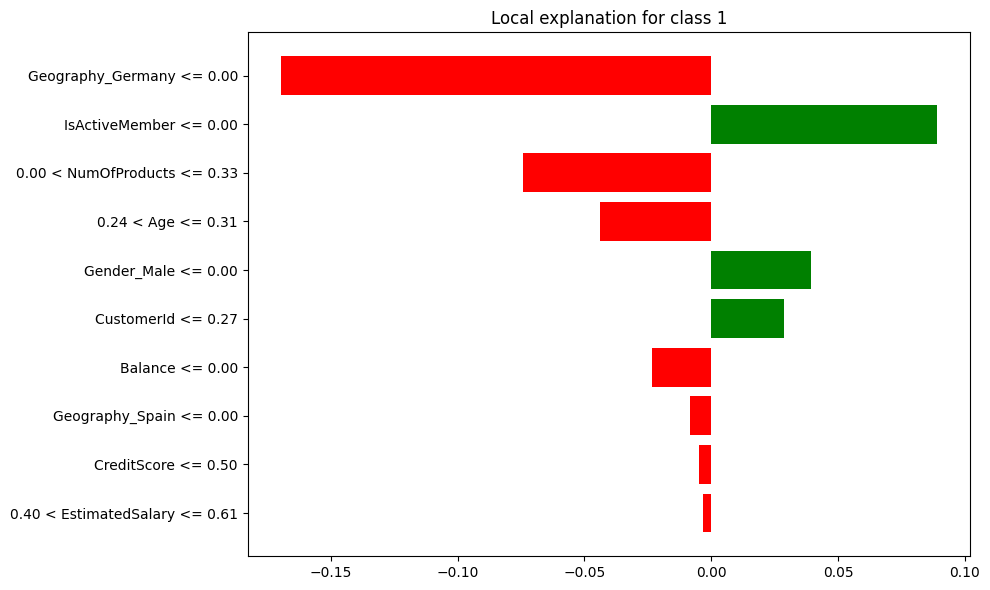

In [10]:
# Predict probabilities and class for any given record (in this case, the first record in the test set)
record_index = 38
predicted_probabilities_rf = clf_RFC.predict_proba(X_test.iloc[[record_index]])
predicted_class_rf = clf_RFC.predict(X_test.iloc[[record_index]])
print(f'Random Forest Predicted Probabilities for Record: {record_index} and probabilities are : {predicted_probabilities_rf} and predicted class is : {predicted_class_rf}')


from lime.lime_tabular import LimeTabularExplainer

# Initialize the LimeTabularExplainer with valid feature names
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=df_train[target].unique(),
                                 mode='classification')

# Explain the prediction of the Random Forest model for the chosen instance
exp = explainer.explain_instance(X_test.iloc[[record_index]].values[0], clf_RFC.predict_proba, num_features = 10)

# Display explanation table inline in Jupyter
display(exp.as_list())

# Convert explanation to matplotlib figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 6)  # optional: make figure larger
plt.tight_layout()
plt.show()


How to interpret this result:  

For record #38, the random forest model classified it as 0 and the predicted probabilities were [0.84, 0.16]  
The bar chart shows that Red bars influence the prediction of 0 (Malignant)



Random Forest Predicted Probabilities for Record: 23 and probabilities are : [[0.24 0.76]] and predicted class is : [1]


[('Age > 0.31', 0.32199173270725007),
 ('Geography_Germany > 0.00', 0.15937454250686134),
 ('IsActiveMember <= 0.00', 0.09029126693718795),
 ('NumOfProducts <= 0.00', 0.059600403402855134),
 ('0.00 < Gender_Male <= 1.00', -0.040677269412176455),
 ('0.48 < CustomerId <= 0.76', -0.020222143219043604),
 ('Balance > 0.48', 0.015367458090249286),
 ('Geography_Spain <= 0.00', -0.00936827867501912),
 ('0.40 < EstimatedSalary <= 0.61', 0.008815939386440829),
 ('0.30 < Tenure <= 0.50', 0.004576946416118467)]

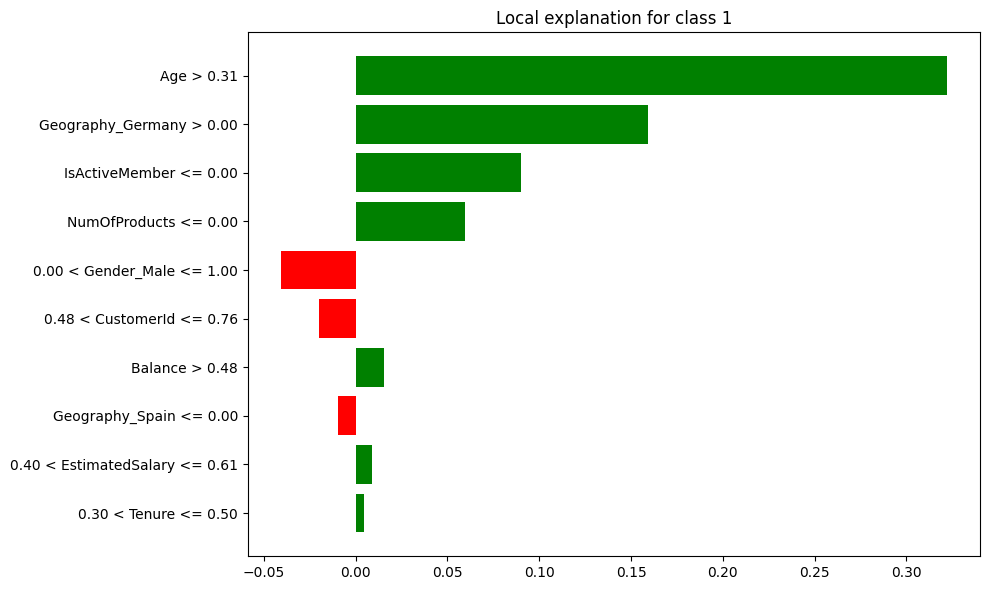

In [11]:
# Predict probabilities and class for any given record (in this case, the first record in the test set)
record_index = 23
predicted_probabilities_rf = clf_RFC.predict_proba(X_test.iloc[[record_index]])
predicted_class_rf = clf_RFC.predict(X_test.iloc[[record_index]])
print(f'Random Forest Predicted Probabilities for Record: {record_index} and probabilities are : {predicted_probabilities_rf} and predicted class is : {predicted_class_rf}')


from lime.lime_tabular import LimeTabularExplainer

# Initialize the LimeTabularExplainer with valid feature names
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=df_train[target].unique(),
                                 mode='classification')

# Explain the prediction of the Random Forest model for the chosen instance
exp = explainer.explain_instance(X_test.iloc[[record_index]].values[0], clf_RFC.predict_proba, num_features = 10)

# Visualize the explanation
# Display explanation table inline in Jupyter
display(exp.as_list())

# Convert explanation to matplotlib figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 6)  # optional: make figure larger
plt.tight_layout()
plt.show()


How to interpret this result:

    For record #23, the random forest model classified it as 1 (Benign) and the predicted probabilities were [0.24, 0.76]
    The bar chart shows that Green bars influence the prediction of 1(Benign)




Pros:¶

    Model Agnostic: LIME is versatile and able to be applied to any machine learning model, including black box models, regardless of complexity or algorithm.
    Local Interpretability: LIME generates local surrogate models to explain individual predictions, providing interpretable explanations for specific instances, and aiding in understanding model behavior at a granular level.
    Versatility: LIME is a versatile tool that can handle various types of data, including structured, unstructured, and mixed data, making it suitable for various domains and applications.

Cons:

    Computational Overhead: Local surrogate models can be computationally expensive, particularly for large datasets or complex models, resulting in longer explanation times and increased computational resources. S* ensitivity to Perturbations: LIME’s sensitivity to perturbations in input data samples can lead to inconsistent explanations and require careful interpretation due to its varying explanations for similar instances.
    Limited Global Understanding: LIME offers individual predictions but may not provide a comprehensive model understanding due to its focus on local interpretability and not capturing global trends or data relationships.

Conclusion
In summary, achieving a balance between the accuracy and explainability of machine learning models is vital. This not only fosters trust among stakeholders but also boosts the confidence of data science teams in the model’s performance, as they can justify its predictions. Tools like LIME play a crucial role by providing clear and easy explanations that are essential for driving innovation and solving complex problems.
